# Introduction:

* Extracting audio embeddings using MetaAI's ImageBind LLMs.
* Clustering audio embeddings using K-Means and Agglomerative Clustering.
* Evaluating Clusters with metrics like Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Index.
* Visualizing Clusters with t-SNE and representative data points.

# Step 1: Install Required Libraries

In [1]:
# Install dependencies
!git clone https://github.com/facebookresearch/ImageBind.git
!pip install -r ImageBind/requirements.txt
!pip install torch matplotlib scikit-learn librosa
!pip install torchvision faiss-cpu

Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 33.03 MiB/s, done.
Resolving deltas: 100% (68/68), done.
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-install-kmhdmplm/pytorchvideo_73630d0590bc44f8a7c28dc410e1b1c3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-install-kmhdmplm/pytorchvideo_73630d0590bc44f8a7c28dc410e1b1c3
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d212663c6a24f373b94cc5d478c8

In [2]:
!ls ImageBind

CODE_OF_CONDUCT.md  imagebind  model_card.md  requirements.txt
CONTRIBUTING.md     LICENSE    README.md      setup.py


In [3]:
import sys
sys.path.append('/content/ImageBind/imagebind')

In [4]:
# Import necessary libraries
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the ImageBind directory
imagebind_dir = os.path.join(current_dir, 'ImageBind') # Changed this line

# Add the ImageBind directory to the system path
sys.path.append(imagebind_dir)

# Now import the modules
from imagebind.models.imagebind_model import imagebind_huge  # or imagebind_large
from imagebind.models.imagebind_model import ModalityType

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [5]:
import torch
from imagebind.models.imagebind_model import imagebind_huge # or imagebind_large

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the imagebind_huge class to get an instance of the model
model = imagebind_huge(pretrained=True)
model.to(device)  # Move the model to the specified device

print("ImageBind model loaded successfully!")

  0%|          | 0.00/4.47G [00:00<?, ?B/s]

ImageBind model loaded successfully!


# Step 2: Load Audio Dataset

In [6]:
import os
import librosa
import numpy as np

# Define the uploaded dataset path
audio_dir = '/content/audios'  # Update if necessary
audio_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]

print(f"Found {len(audio_files)} audio files.")

# Function to load audio with librosa
def load_audio(file_path, sr=16000):
    """
    Load an audio file, resample it to 16 kHz, and return the waveform.
    """
    waveform, _ = librosa.load(file_path, sr=sr, mono=True)
    return waveform

# Load audio waveforms
audio_waveforms = [load_audio(file) for file in audio_files]

# Check the loaded waveforms
print(f"Loaded {len(audio_waveforms)} audio waveforms.")
print(f"Example waveform length: {len(audio_waveforms[0])}")



Found 20 audio files.
Loaded 20 audio waveforms.
Example waveform length: 480000


In [13]:
!pip install torch torchvision torchaudio transformers librosa


In [14]:
import os
import librosa

# Define audio dataset directory
audio_dir = '/content/audios'  # Update with your dataset path
audio_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]

print(f"Found {len(audio_files)} audio files.")

# Load audio waveforms
def load_audio(file_path, sr=16000):
    waveform, _ = librosa.load(file_path, sr=sr, mono=True)
    return waveform

# Preprocess all audio files
audio_waveforms = [load_audio(file) for file in audio_files]
print(f"Loaded {len(audio_waveforms)} audio waveforms.")


Found 20 audio files.
Loaded 20 audio waveforms.


# Step 3: Generate Embeddings

In [15]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch

# Load Wav2Vec 2.0 processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

# Ensure the model is on the same device as the tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Generate embeddings for all audio files
def extract_wav2vec_embeddings(waveform, model, processor, sr=16000):
    # Preprocess audio waveform
    inputs = processor(waveform, sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Average over time dimension
    return embeddings.cpu().numpy()

# Extract embeddings for all audio files
audio_embeddings = [extract_wav2vec_embeddings(waveform, model, processor) for waveform in audio_waveforms]
audio_embeddings = np.vstack(audio_embeddings)

print(f"Generated audio embeddings shape: {audio_embeddings.shape}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Generated audio embeddings shape: (20, 768)


# Step 4: Clustering

**K-Means Clustering**

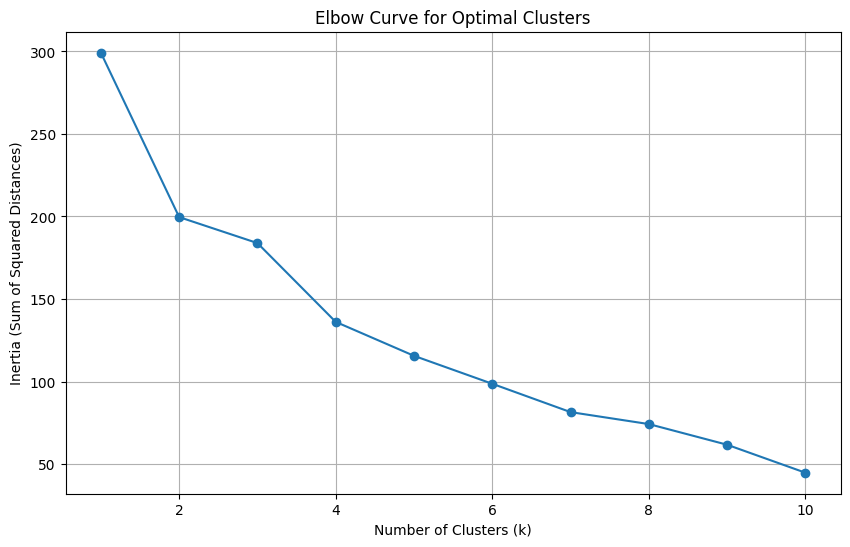

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Range of clusters to evaluate
cluster_range = range(1, 11)

# Calculate inertia for each number of clusters
inertia_values = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(audio_embeddings)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.title("Elbow Curve for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.grid()
plt.show()


In [16]:
from sklearn.cluster import KMeans

# Perform K-Means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(audio_embeddings)

print(f"K-Means Cluster Assignments: {kmeans_labels}")


K-Means Cluster Assignments: [4 4 2 2 2 2 4 0 2 4 3 2 2 0 2 2 1 4 4 1]


**Agglomerative Clustering**

In [17]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative clustering
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
agg_labels = agg_clustering.fit_predict(audio_embeddings)

print(f"Agglomerative Cluster Assignments: {agg_labels}")


Agglomerative Cluster Assignments: [0 4 1 1 1 1 0 3 3 0 2 1 1 3 1 1 0 0 0 0]


# Step 5: Evaluate Clustering Quality
Evaluate clustering using metrics like Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Index.

In [18]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Evaluate K-Means clustering
kmeans_silhouette = silhouette_score(audio_embeddings, kmeans_labels)
kmeans_db = davies_bouldin_score(audio_embeddings, kmeans_labels)
kmeans_ch = calinski_harabasz_score(audio_embeddings, kmeans_labels)

# Print evaluation metrics
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"K-Means Davies-Bouldin Index: {kmeans_db}")
print(f"K-Means Calinski-Harabasz Index: {kmeans_ch}")


K-Means Silhouette Score: 0.16678769886493683
K-Means Davies-Bouldin Index: 1.0152196177717325
K-Means Calinski-Harabasz Index: 5.960820703718926


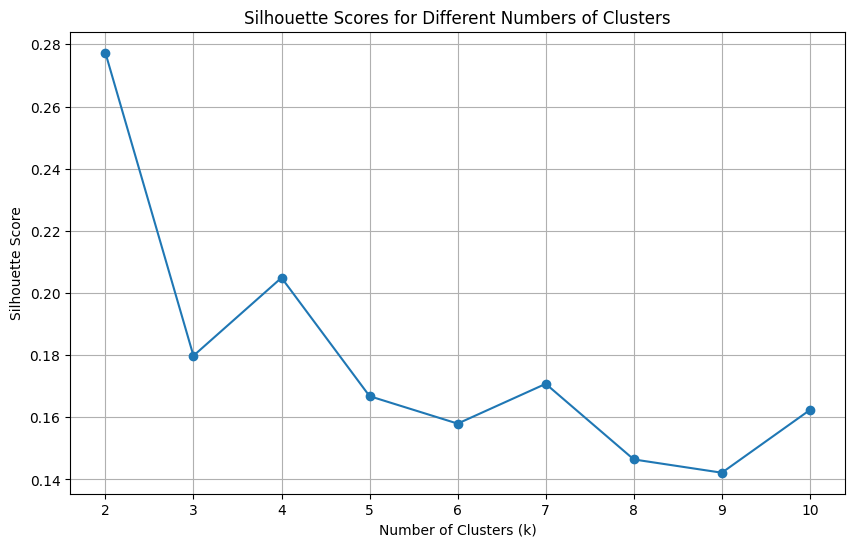

In [25]:
from sklearn.metrics import silhouette_score
import numpy as np

# Calculate silhouette scores for different cluster numbers
silhouette_scores = []
for k in range(2, 11):  # Silhouette is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(audio_embeddings)
    score = silhouette_score(audio_embeddings, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()


In [10]:
# Preprocess audio with correct shape
def preprocess_audio(waveform, sr=16000, max_length=48000):
    """
    Convert a waveform to a PyTorch tensor, add a channel dimension, and pad/truncate to a fixed length.
    """
    # Resample to the target sampling rate if necessary
    if sr != 16000:
        waveform = librosa.resample(waveform, orig_sr=sr, target_sr=16000)

    # Convert to tensor
    tensor = torch.tensor(waveform, dtype=torch.float32)

    # Pad or truncate to the fixed length
    if len(tensor) < max_length:
        tensor = F.pad(tensor, (0, max_length - len(tensor)))  # Pad at the end
    else:
        tensor = tensor[:max_length]  # Truncate

    # Add channel dimension (1 channel for mono audio)
    tensor = tensor.unsqueeze(0)  # Shape: [1, num_samples]
    return tensor.to(device)

# Preprocess all audio waveforms
audio_tensors = [preprocess_audio(waveform) for waveform in audio_waveforms]

# Check tensor shapes
print(f"Processed audio tensor shape: {audio_tensors[0].shape}")  # Should be [1, 1, 48000]


Processed audio tensor shape: torch.Size([1, 48000])


In [11]:
# Stack tensors into a batch
audio_tensors_batch = torch.stack(audio_tensors)  # Shape: [batch_size, 1, num_samples]
print(f"Batched audio tensor shape: {audio_tensors_batch.shape}")


Batched audio tensor shape: torch.Size([64, 1, 48000])


In [13]:
import librosa
import librosa.display

# Convert waveform to mel-spectrogram
def waveform_to_mel(waveform, sr=16000, n_mels=128, n_fft=2048, hop_length=512):
    """
    Convert an audio waveform to a mel-spectrogram.
    """
    # Compute mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=waveform, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    # Convert to log scale (dB)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

# Convert all audio waveforms
mel_spectrograms = [waveform_to_mel(waveform) for waveform in audio_waveforms]

# Check the shape of a sample mel-spectrogram
print(f"Mel-spectrogram shape: {mel_spectrograms[0].shape}")  # Should be [n_mels, time_frames]


Mel-spectrogram shape: (128, 938)


In [14]:
# Convert mel-spectrograms to tensors
def preprocess_mel_spectrogram(mel_spectrogram, max_width=300):
    """
    Prepare mel-spectrogram tensor for ImageBind.
    """
    # Convert to tensor
    mel_tensor = torch.tensor(mel_spectrogram, dtype=torch.float32)
    # Add a channel dimension
    mel_tensor = mel_tensor.unsqueeze(0)  # Shape: [1, n_mels, time_frames]
    # Pad or truncate width to a fixed size (max_width)
    if mel_tensor.shape[-1] < max_width:
        mel_tensor = F.pad(mel_tensor, (0, max_width - mel_tensor.shape[-1]))  # Pad width
    else:
        mel_tensor = mel_tensor[:, :, :max_width]  # Truncate width
    return mel_tensor

# Preprocess all mel-spectrograms
mel_tensors = [preprocess_mel_spectrogram(mel) for mel in mel_spectrograms]

# Stack tensors into a batch
mel_tensors_batch = torch.stack(mel_tensors).to(device)  # Shape: [batch_size, 1, n_mels, max_width]
print(f"Batched mel-spectrogram tensor shape: {mel_tensors_batch.shape}")


Batched mel-spectrogram tensor shape: torch.Size([64, 1, 128, 300])


In [16]:
import torch.nn.functional as F

# Define the target size for square tensors (e.g., 224x224)
target_size = 224

def resize_to_square(mel_tensor, target_size=224):
    """
    Resize a mel-spectrogram tensor to a square shape using interpolation.
    """
    mel_tensor = mel_tensor.unsqueeze(0)  # Add a batch dimension
    mel_tensor_resized = F.interpolate(
        mel_tensor, size=(target_size, target_size), mode="bilinear", align_corners=False
    )
    return mel_tensor_resized.squeeze(0)  # Remove the batch dimension

# Resize all mel-spectrogram tensors
square_mel_tensors = [resize_to_square(mel) for mel in mel_tensors]

# Stack resized tensors into a batch
square_mel_tensors_batch = torch.stack(square_mel_tensors).to(device)
print(f"Square mel-spectrogram tensor shape: {square_mel_tensors_batch.shape}")  # Should be [batch_size, 1, 224, 224]


Square mel-spectrogram tensor shape: torch.Size([64, 1, 224, 224])


In [18]:
import torch.nn.functional as F

# Define the target size for square tensors
target_size = 224

def resize_and_pad_to_square(mel_tensor, target_size=224):
    """
    Resize and pad a mel-spectrogram tensor to a square shape (e.g., 224x224).
    """
    # Add batch dimension for processing
    mel_tensor = mel_tensor.unsqueeze(0)

    # Resize the tensor
    mel_tensor_resized = F.interpolate(
        mel_tensor, size=(target_size, target_size), mode="bilinear", align_corners=False
    )
    return mel_tensor_resized.squeeze(0)  # Remove batch dimension

# Apply resizing and padding
square_mel_tensors = [resize_and_pad_to_square(mel) for mel in mel_tensors]
square_mel_tensors_batch = torch.stack(square_mel_tensors).to(device)

# Check final shape
print(f"Square mel-spectrogram tensor shape: {square_mel_tensors_batch.shape}")  # Should be [batch_size, 1, 224, 224]


Square mel-spectrogram tensor shape: torch.Size([64, 1, 224, 224])


In [20]:
print(square_mel_tensors_batch.shape)


torch.Size([64, 1, 224, 224])


In [21]:
print(f"Tensor device: {square_mel_tensors_batch.device}")
print(f"Model device: {next(model.parameters()).device}")


Tensor device: cuda:0
Model device: cuda:0


# Step 6: Visualize Clusters
Reduce the dimensionality of the embeddings using PCA (Principal Component Analysis) and visualize the clusters.

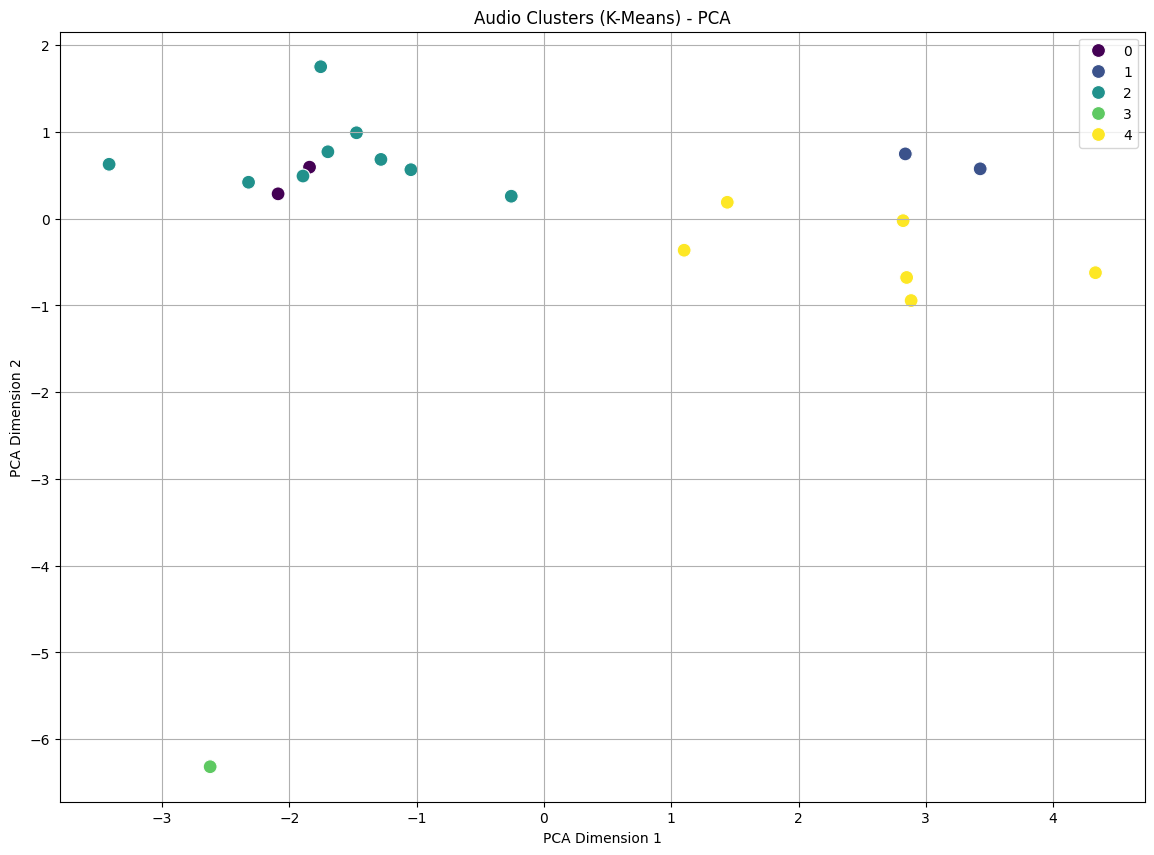

In [23]:
from sklearn.decomposition import PCA

# Reduce embeddings to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(audio_embeddings)

# Plot clusters
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=kmeans_labels,
    palette="viridis",
    s=100
)
plt.title("Audio Clusters (K-Means) - PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid()
plt.show()



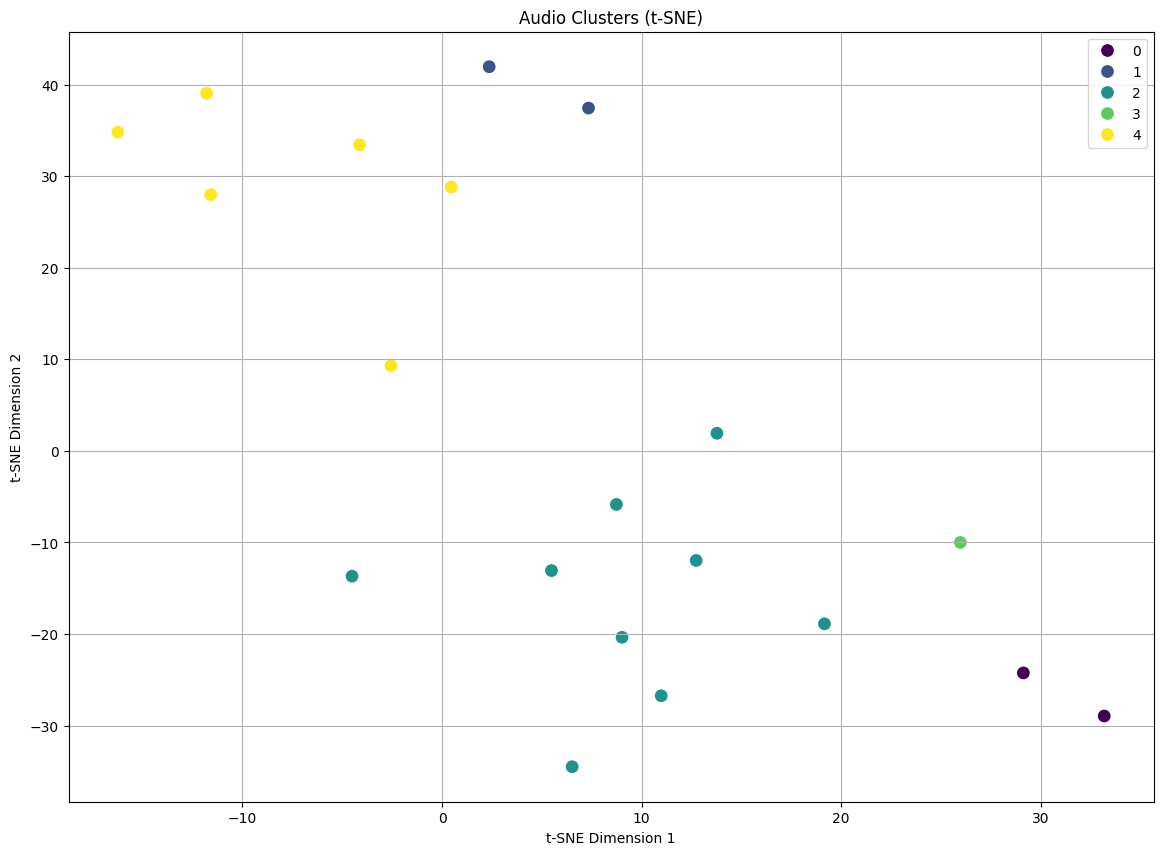

In [26]:
from sklearn.manifold import TSNE
import seaborn as sns

# Adjust perplexity based on dataset size
perplexity = min(30, len(audio_embeddings) // 3)

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
reduced_embeddings = tsne.fit_transform(audio_embeddings)

# Plot clusters
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=kmeans_labels,  # Use cluster labels from K-Means
    palette="viridis",
    s=100
)
plt.title("Audio Clusters (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()


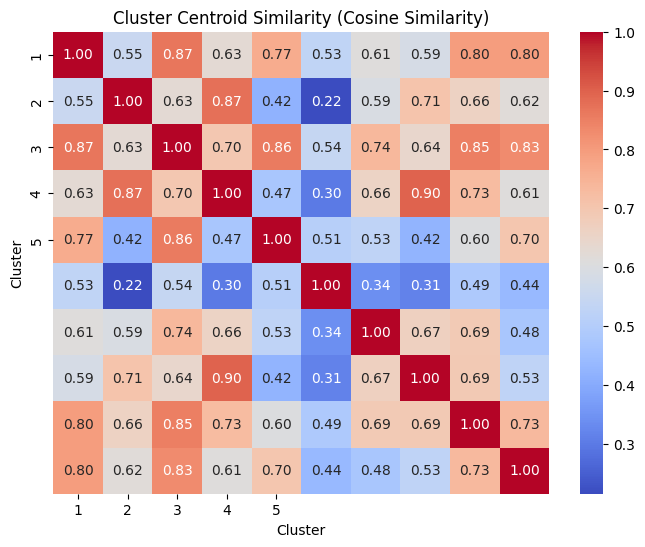

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Calculate cosine similarity between cluster centroids
centroids = kmeans.cluster_centers_
similarity_matrix = cosine_similarity(centroids)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=range(1, num_clusters+1), yticklabels=range(1, num_clusters+1))
plt.title("Cluster Centroid Similarity (Cosine Similarity)")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()


In [28]:
# Representative audio samples
for cluster in range(num_clusters):
    cluster_indices = np.where(kmeans_labels == cluster)[0]
    representative_index = cluster_indices[0]  # First item in the cluster
    print(f"Cluster {cluster}: Representative Audio File - {audio_files[representative_index]}")


Cluster 0: Representative Audio File - /content/audios/ballad.wav
Cluster 1: Representative Audio File - /content/audios/amal.wav
Cluster 2: Representative Audio File - /content/audios/blues.wav
Cluster 3: Representative Audio File - /content/audios/bartok.wav
Cluster 4: Representative Audio File - /content/audios/acomic2.wav


In [29]:
!pip install plotly


In [30]:
import plotly.express as px
import pandas as pd

# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame({
    'x': reduced_embeddings[:, 0],
    'y': reduced_embeddings[:, 1],
    'Cluster': kmeans_labels,
    'Audio File': [os.path.basename(file) for file in audio_files]
})

# Create an interactive scatter plot
fig = px.scatter(
    tsne_df, x='x', y='y', color='Cluster', text='Audio File',
    title="Interactive t-SNE Visualization of Audio Clusters"
)
fig.update_traces(marker=dict(size=12))
fig.show()
